In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import sys
sys.path.append("../utility")
sys.path.append("../train")
from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc
import lqr
import time

In [14]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
method_index = 0
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
# suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
suffix = "MountainCarContinuous1_26"
env_name = "MountainCarContinuous-v0"

In [15]:
Kd = np.load("Prediction_Results/"+"Kd_"+env_name+"_KoopmanDerivative"+".npy")
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
LiftFunc = DerivativeLiftFunc(env_name,Nstate,udim)
NKoopman = LiftFunc.NKoopman
eig = np.linalg.eigvals(Kd)
print("max eig val:{}".format(max(eig)))
# print(Kd)

max eig val:(1.000000000000103+0j)


In [16]:
def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.8*np.eye(1)
        reset_state=  [0.0,0.0,-1.0,0.1]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-3.0,6.0]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = np.eye(1)
        reset_state = [-3.0,2.0]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.1
        R = 0.01*np.eye(1)
        reset_state = [-0.3,0.1]  
        x_ref[0] = 0.45
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref
    
def criterion(env_name,observations):
    if env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
    return err

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss

0.01961048273921745 15.933115506599965


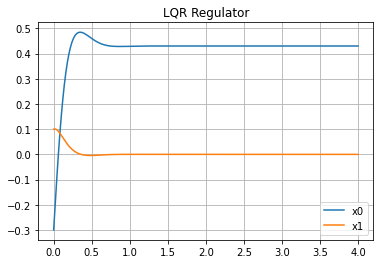

In [17]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
# reset_state=  [0.0,0.0,-1.0,0.1]
uval = 1 
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,uval*R)
observation_list = []
observation = np.array(env.reset_state(reset_state))
x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
observation_list.append(x0[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    # env.render()
    u = -Kopt*(x0-x_ref_lift)
    observation, reward, done, info = env.step(u[0,0])
    x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)
observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
np.save("SingleControlResults/"+env_name+"_KoopmanDerivative_obs.npy",observations)
Err = criterion(env_name,observations)
loss = Cost(observations,u_list,Q[:Nstate,:Nstate],uval*R,x_ref)
print(Err,loss)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.savefig("SingleControlResults/"+env_name+"_KoopmanDerivative.png")
plt.show()